# **Marsden Fund Analysis**

This notebook contains the code to analyse the Marsden Fund data. The data is obtained from the **Marsden Fund [website](https://www.royalsociety.org.nz/what-we-do/funds-and-opportunities/marsden/)** and contains information on the funded projects, including the project title, abstract, and the name of the researchers involved. The data is stored in a CSV file and is read into a pandas dataframe for analysis.

**You need the files from the Marsen fund per year in the folder of this script**

Also, you need this file: **files_in_folder.csv**

### Initiation ##

In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import numpy as np
import re
from skimpy import skim

# Configure working directory based on the operating system
if os.name == 'nt':
    os.chdir('D:\\Nextcloud\\Dropbox\\marsden\\marsden\\work_files')
else:
    os.chdir('/home/martien/Nextcloud/Dropbox/marsden/marsden/work_files')

# Marsden panels and university name mappings

marsden_panels_short = {
    'BMS': 'Biomedical Sciences',
    'CMP': 'Cellular Biology',
    'ESA': 'Earth Sciences',
    'EEB': 'Ecology and Behaviour',
    'EHB': 'Economics and Behavioural',
    'EIS': 'Engineering Sciences',
    'HUM': 'Humanities',
    'MIS': 'Math and Info Sciences',
    'PCB': 'Physics Chemistry Bio',
    'SOC': 'Social Sciences',
    'MFC': 'MFC',
    'PSE': 'PSE'
}

unis = {
    "The University of Auckland": "Auckland",
    "University of Otago": "Otago",
    "Victoria University of Wellington": "VUW",
    "University of Canterbury": "Canterbury",
    "Massey University": "Massey",
    "University of Waikato": "Waikato",
    "University of Auckland": "Auckland",
    "GNS Science": "GNS",
    "Auckland University of Technology": "AUT",
    "National Institute of Water and Atmospheric Research Ltd": "NIWA",
    "National Institute of Water and Atmospheric Research": "NIWA",
    "Massey University Manawatu": "Massey",
    "Massey University Auckland": "Massey",
    "Manaaki Whenua Landcare Research": "Landcare",
    "NIWA": "NIWA",
    "Plant & Food Research": "Plant & Food",
    "Landcare Research": "Landcare",
    "Lincoln University": "Lincoln",
    "Cawthron Institute": "Cawthron",
    "Malaghan Institute of Medical Research": "Malaghan",
    "The University of Waikato": "Waikato",
    "Te Whare Wānanga o Awanuiārangi": "Awanuiārangi",
    "Institute of Environmental Science and Research": "ESR",
    "Scion": "Scion",
    "BioArch South": "BioArch",
    "Heather Came & Associates, NZ": "HC Associates",
    "Museum of New Zealand Te Papa Tongarewa": "Te Papa",
    "Takarangi Research Ltd": "Takarangi",
    "Lincoln Agritech Ltd": "Lincoln",
    "Motu Economic & Public Policy Research Trust": "Motu",
    "Pūrangakura Ltd": "Pūrangakura",
    "Māori and Indigenous Analysis Ltd (MAIA)": "MAIA",
    "Bodeker Scientific": "Bodeker",
    "Speedy Research & Consulting": "Speedy Research",
    "Massey University Wellington": "Massey",
    "University of Otago, Christchurch": "Otago",
    "Te Wananga o Raukawa": "Raukawa",
    "California Institute of Technology": "Caltech",
    "Victoria University of Wellinton": "VUW",
    "Institue of Geophysics": "Geophysics",
    "Canterbury Museum": "Canterbury Museum",
    "AgResearch": "AgResearch",
    "Industrial Research Ltd": "Industrial Research",
    "Plant and Food Research": "Plant & Food",
    "Dragonfly Data Science": "Dragonfly",
    "Auckland Mathematics and Computation Limited": "Auckland Math & Comp",
    "Van der Veer Institute for Parkinson's and Brain Research": "Van der Veer",
    "Crop & Food Research": "Crop & Food",
}


### **Helper Functions**

Function to clean and preprocess text

In [2]:
def simple_clean_text(text):
    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'_x[0-9A-Fa-f]+_', '', text)  # Remove special encoding (e.g., _x000D_)
    text = re.sub(r'\n', ' ', text)  # Replace newlines with space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    text = text.replace("new zealand", "new_zealand")  # Treat "New Zealand" as one token
    text = text.replace("te reo", "te_reo")
    text = text.replace("te iwi", "te_iwi")

    return text

Function to prepare for word cloud

In [3]:
def clean_text(df, variable, additional_stopwords, year):
    # TF-IDF Vectorization with custom stopwords
    # Define custom stopwords
    #custom_stopwords = ['new', 'use']  # Add other common words as needed
    custom_stopwords = list(ENGLISH_STOP_WORDS.union(additional_stopwords))

    # TF-IDF Vectorization with custom stopwords
    tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features=100, min_df=2)
    tfidf_matrix_cleaned = tfidf_vectorizer.fit_transform(df[variable].dropna())

    # Apply Truncated SVD for topic modeling
    svd_model_cleaned = TruncatedSVD(n_components=5, random_state=42)
    svd_matrix_cleaned = svd_model_cleaned.fit_transform(tfidf_matrix_cleaned)

    # Extract main terms associated with each topic
    terms = tfidf_vectorizer.get_feature_names_out()
    topics_cleaned = {}
    for i, comp in enumerate(svd_model_cleaned.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
        #topics_cleaned[year*10+i+1] = [term for term, _ in sorted_terms]
        topics_cleaned[i+1] = [term for term, _ in sorted_terms]

    # Display topics
    if year in [2024, 2008]:
        print("Refined Topics from Cleaned Summaries:")
        for topic, terms in topics_cleaned.items():
            print(f"{topic}: {', '.join(terms)}")

    df = df.assign(Assigned_Topic = np.argmax(svd_matrix_cleaned, axis=1) + 1)  # Adding 1 to make topics 1-indexed

    return df, topics_cleaned, svd_matrix_cleaned, svd_model_cleaned

In [4]:
def display_topics(topics_cleaned, year):
    # Convert the topics dictionary into a DataFrame for better visualization
    topics_df = pd.DataFrame.from_dict(topics_cleaned, orient='index')#.reset_index()
    topics_df.index.name="Topic"

    # Rename columns for clarity
    topics_df.columns = [f"term_{x+1}" for x in topics_df]
    topics_df = topics_df.assign(year=year).set_index('year', append=True)

    # Display the DataFrame
    #print(topics_df)
    return topics_df

Function to show word cloud

In [5]:
def display_wordcloud(topics_cleaned, year):
    # Generate WordCloud for all topics combined
    all_terms = ' '.join([' '.join(terms) for terms in topics_cleaned.values()])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_terms)

    # Display the WordCloud
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of Top Terms Across Topics  for {year}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'./word_clouds/wordcloud_{year}.png')
    if year in [2024, 2008]:
        plt.show()
    plt.close()

    # Count term frequencies across all topics
    term_counts = Counter([term for terms in topics_cleaned.values() for term in terms])
    top_terms = term_counts.most_common(10)

    return pd.DataFrame(top_terms, columns=["Term", "Frequency"]).assign(year=year)


Function to show a bar with dominant topics


In [6]:
def bar_topics(data, year):

    # Assuming the new DataFrame is named `data` and includes the column 'Assigned_Topic'
    # Create the bar chart for the number of projects per topic
    threshold = 0.6  # Adjust threshold if needed

    plt.figure(figsize=(6, 4))  # Adjust figure size for better display
    ax = data['Assigned_Topic'].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f"Number of Projects per Dominant Topic for Year {year}", fontsize=14)
    plt.ylabel("Number of Projects", fontsize=12)
    plt.xlabel("Dominant Topic", fontsize=12)

    # Rotate x-tick labels for better visibility
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f'./barplots/bargraph_{year}.png')
    if year in [2024, 2008]:
        plt.show()
    plt.close()


## **Main function to analyse Marsden Fund data** ##

**The function below generats two data frames, one with projects (df_all) and one with teams and names (df_tms).**




In [7]:
def load_data(file_name):
    """Load the CSV and return a dictionary of year data."""
    df_files = pd.read_csv(file_name).set_index('year')
    return df_files.to_dict(orient='index')

def clean_teams_data(dft, year):
    """Clean and process a team DataFrame."""
    # Rename columns and preprocess text
    dft = dft.rename(columns={'Institution': 'Organisation'})

    # Dictionary for names
    name_replacements = {
        "Dr Y-H Chooi": "Dr YH Chooi",
        "Dr J-C Han": "Dr JC Han",
        "Professor JB-J Lee-Morgan": "Professor JBJ Lee-Morgan",
        " PB Rainey": "Mx PB Rainey",
        "Dr OJ-M Lamiable": "Dr OJM Lamiable",
        "Professor Dame Carol Robinson": "Professor C Robinson",
        "Dr M-L Ward": "Dr ML Ward",
        " H Sadler": "Mx H Sadler",
        "Professor WThF den Hollander": "Professor WTHF den Hollander",
        "Dr M-C Liang": "Dr MC Liang",
        "Dr J-M Lett": "Dr JM Lett",
        "Associate Professor Y-C Tzeng": "Associate Professor YC Tzeng",
        " A Mead": "Mx A Mead",
        " ER Peterson": "Mx ER Peterson",
        "Professor Dame Anne Salmond": "Professor A Salmond",
        "Dr A-C Alderkamp": "Dr AC Alderkamp",
        "M Shippam": "Mx M Shippam",
        "MB Mitchell": "Mx MB Mitchell",
        'Dr Samarth': 'Dr S Kulshrestha',
    }
    # Apply name replacements
    dft['Investigator'] = dft['Investigator'].replace(name_replacements)

    # Title normalization mapping
    title_mapping = {
        "Dr": "Dr",
        "Professor": "Professor",
        "Associate Professor": "Assoc Prof",
        "Prof": "Professor",
        "Assoc Prof": "Assoc Prof",
        "Mr": "Mx",
        "Ms": "Mx",
        "Mrs": "Mx",
        "Mx": "Mx",
        "Distinguished Professor": "Professor",
        "Emeritus Professor": "Professor",
        "Professor Sir": "Professor",
        "Assistant Professor": "Assoc Prof",
        "Miss": "Mx",
        "Professor Dame": "Professor",
        "Sir": "Professor",
        "Dame": "Professor",
    }


    dft = dft.assign(
        **{'Project ID': lambda x: x['Project ID'].ffill()},
        Investigator=lambda x: x['Investigator']
        .str.strip()
        .str.replace(r"[\\']", "", regex=True),
        Organisation=lambda x: x['Organisation']
        .str.strip()
        .str.replace(r"[\\']", "", regex=True)
    )
    # Extract titles, first names, and surnames with regex
    dft[['Title', 'FirstNames', 'Surname']] = dft['Investigator'].str.extract(
        r'^(Dr|Prof|Assoc Prof|Professor|Associate Professor|Professor Dame|Emeritus Professor|Distinguished Professor|Miss|Mr|Ms|Mrs|Mx|Assistant Professor|Professor Sir|Sir|Dame)\s+((?:[A-Z]{1,5}(?:\s[A-Z]{1,5})*)?)\s+([\w\'\- ]+)$'
    )

    # Map the titles to normalized short titles
    dft['Short_title'] = dft['Title'].map(title_mapping).fillna('Unknown')


    # Generate FullName and add year
    dft = dft.assign(
        FullName=lambda x: x['Surname'].str.strip() + ", " + x['FirstNames'].str.strip(),
        year=year
    )
    # Keep only relevant columns
    columns_to_keep = ['year', 'Project ID', 'Investigator', 'Role', 'Organisation', 'Title', 'FirstNames', 'Surname', 'Short_title', 'FullName']
    return dft[columns_to_keep]


def process_team(df_book, year_entry, year, df_tms):
    """Process a single year's data."""
    if year == 2015:
        accept_years = ['2015 teams', '2014 teams', '2013 teams', '2012 teams', '2011 teams', '2010 teams', '2009 teams', '2008 teams']
        # Handle multiple sheets for 2015
        for key, dft in df_book.items():
            #print('Length tems sheet: ', len(dft))
            if (key in accept_years) and (re.match(r'\d{4} teams', key)):  # Match keys like '2015 teams'
                match = re.search(r'\d{4}', key)
                if match:
                    team_year = int(match.group())
                    dft = clean_teams_data(dft, team_year)
                    df_tms.append(dft)
    else:
        # Handle single team sheet for other years
        dft = df_book[year_entry['team_sheet']]
        #print('Length tems sheet: ', len(dft))
        dft = clean_teams_data(dft, year)
        df_tms.append(dft)


def process_main_sheet(df, year_entry, year):
    """Process the main sheet for a given year."""
    if 'Year' in df.columns:
        df = df.rename(columns={'Year': 'year'})
    else:
        df = df.assign(year=year)

    rename_dict = {v: k for k, v in year_entry.items() if v and k not in ['file', 'sheet']}
    df = df.rename(columns=rename_dict)

    df = df.assign(
        Panel=lambda x: x['Panel'].str.split(' & ').str[0],  # Extract the first mnemonic
        Cleaned_Summary=lambda x: x['Summary'].dropna().apply(simple_clean_text),
        Panel_Name=lambda x: x['Panel'].map(marsden_panels_short),
        Institution=lambda x: x['Organisation'].map(unis)
    )
    return df


def create_df(file_name):
    """Main function to process all years and return DataFrames."""
    data_dict = load_data(file_name)
    df_all = []
    df_tms = []

    for year, year_entry in data_dict.items():
        if year > 20:  # Skip invalid years
            #print(year, year_entry, '\n')
            df_book = pd.read_excel(year_entry['file'], sheet_name=None)
            df = df_book[year_entry['sheet']]

            # Process main data sheet
            df = process_main_sheet(df, year_entry, year)
            df_all.append(df)

            # Process team sheets
            process_team(df_book, year_entry, year, df_tms)

    df_all = pd.concat(df_all).drop_duplicates(subset=['Project ID']).sort_values('Project ID', ascending=False)
    df_tms = pd.concat(df_tms).sort_values('Project ID', ascending=False)
    return df_all, df_tms


# Example usage
df_all, df_tms = create_df('files_in_folder.csv')


In [8]:
# Check the main data frame
skim(df_all)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1893   │ │ string      │ 12    │                                                          │
│ │ Number of columns │ 14     │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0      ┃ p25     ┃ p50     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ Funding       │   0 │     0 │  605900 │  284700 │  158000 │  300000 │  653300 │  841000 │ 3000000 │   ▇▇   │  │
│ │ year          │   0 │     0 │    2016 │   4.812 │    2008 │    2012 │    2017 │    2020 │    2024 │ ▆▆▃▇▇▇ │  │
│ └───────────────┴─────┴───────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA       ┃ NA %       ┃ words per row           ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Project ID                          │        0 │          0 │                       1 │               1893 │  │
│ │ Media Title                         │     1780 │      94.03 │                     0.9 │               1700 │  │
│ │ Title                               │        0 │          0 │                      11 │              20698 │  │
│ │ Contact Investigator                │        0 │          0 │                     3.2 │               5982 │  │
│ │ Organisation                        │        0 │          0 │                     3.4 │               6383 │  │
│ │ Panel                               │        0 │          0 │                       1 │               1893 │  │
│ │ Category                            │      117 │       6.18 │                    0.94 │               1782 │  │
│ │ Media Summary                       │     1780 │      94.03 │                     4.5 │               8595 │  │
│ │ Summary                             │        0 │          0 │                     170 │             320633 │  │
│ │ Cleaned_Summary                     │        0 │          0 │                     170 │             319844 │  │
│ │ Panel_Name                          │        0 │          0 │                     2.4 │               4507 │  │
│ │ Institution                         │        0 │          0 │                       1 │               1936 │  │
│ └─────────────────────────────────────┴──────────┴────────────┴─────────────────────────┴────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [9]:
# Check the teams file:
skim(df_tms)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5700   │ │ string      │ 9     │                                                          │
│ │ Number of columns │ 10     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %   ┃ mean   ┃ sd       ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ year             │    0 │      0 │   2017 │    4.813 │   2008 │   2013 │   2017 │   2021 │  2024 │ ▆▅▃▇▇▇  │  │
│ └──────────────────┴──────┴────────┴────────┴──────────┴────────┴────────┴────────┴────────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA     ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Project ID                 │      0 │          0 │                            1 │                     5700 │  │
│ │ Investigator               │      0 │          0 │                          3.2 │                    18033 │  │
│ │ Role                       │      0 │          0 │                            1 │                     5700 │  │
│ │ Organisation               │      0 │          0 │                          3.5 │                    19843 │  │
│ │ Title                      │      0 │          0 │                          1.1 │                     6508 │  │
│ │ FirstNames                 │      0 │          0 │                            1 │                     5702 │  │
│ │ Surname                    │      0 │          0 │                            1 │                     5820 │  │
│ │ Short_title                │      0 │          0 │                          1.1 │                     6464 │  │
│ │ FullName                   │      0 │          0 │                            2 │                    11522 │  │
│ └────────────────────────────┴────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

**The function below generates word clouds and graphs with dominant topic as well as data frames with topics per year and word cloud top terms.**

Refined Topics from Cleaned Summaries:
1: cells, models, mechanisms, novel, evolution, determine, provide, proteins, molecular, understanding
2: cells, proteins, cell, mechanisms, signalling, determine, disease, pathways, molecular, human
3: theory, model, growth, problems, effective, proposal, fundamental, develop, dynamics, theoretical
4: social, economic, new_zealand, changes, analyse, growth, pathways, maori, cells, explore
5: models, provide, evolution, systems, analyse, data, genetic, analysis, studies, develop


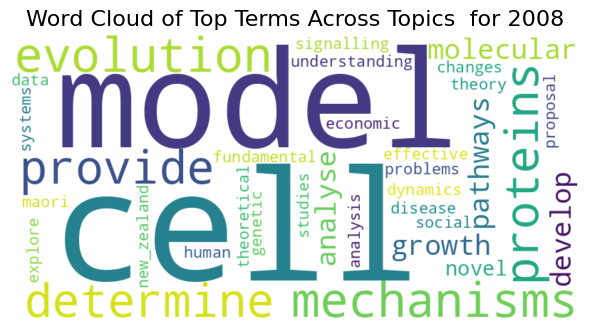

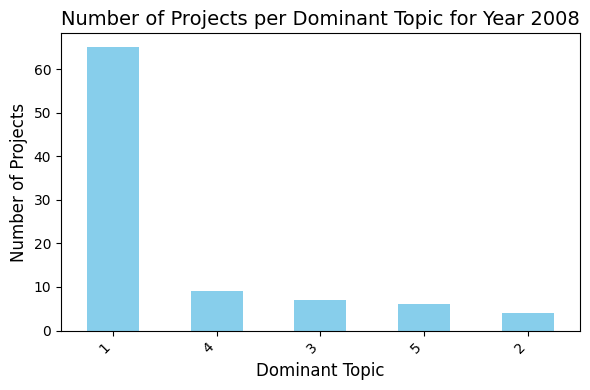

Refined Topics from Cleaned Summaries:
1: māori, indigenous, aotearoa, understanding, new_zealand, knowledge, data, cells, potential, future
2: māori, indigenous, cultural, aotearoa, historical, pacific, new_zealand, health, wellbeing, future
3: indigenous, aotearoa, new_zealand, change, theory, pacific, natural, knowledge, diversity, understanding
4: optical, data, properties, information, light, materials, unique, modelling, like, theory
5: data, complex, mechanisms, proteins, models, model, historical, stress, behaviour, human


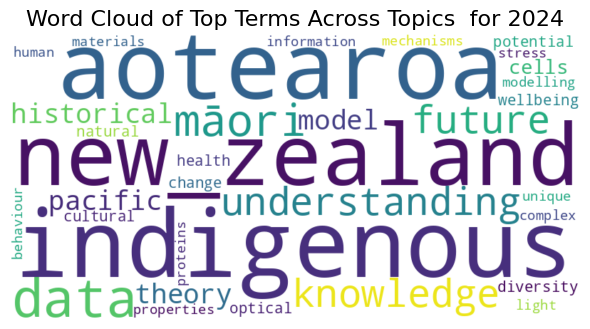

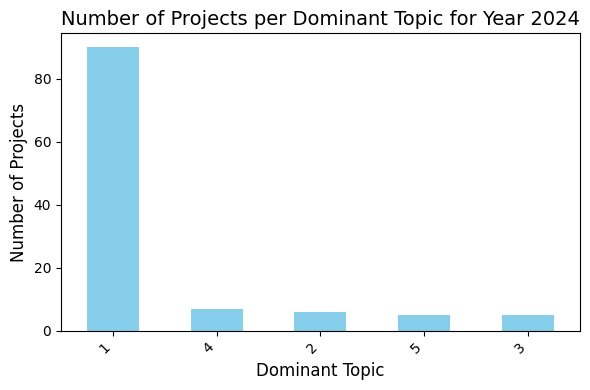

In [10]:

def analyze_text_by_year(df_all, additional_stopwords):
    """Analyzes text by year and produces a word cloud and bar graph for each year."""
    df_year_all, df_topics_all , df_wordcloud_top_terms_all = [], [], []

    # Iterate over unique years in the DataFrame
    for year in sorted(df_all['year'].unique()):
        #print(f"Processing year: {year}")
        # Filter data for the current year
        df_year = df_all[df_all['year'] == year]
        # Clean text and perform topic modeling
        df_year, topics_cleaned, svd_matrix_cleaned, svd_model_cleaned = clean_text(df_year, 'Cleaned_Summary', additional_stopwords, year )
        # Display topics as a DataFrame
        topics_df = display_topics(topics_cleaned, year)
        # Generate and display the word cloud
        wordcloud_top_terms = display_wordcloud(topics_cleaned, year)
        # Create a bar chart for the dominant topics
        bar_topics(df_year, year)

        df_year_all.append(df_year)
        df_topics_all.append(topics_df)
        df_wordcloud_top_terms_all.append(wordcloud_top_terms)

    return pd.concat(df_year_all), pd.concat(df_topics_all), pd.concat(df_wordcloud_top_terms_all)

additional_stopwords = ['new', 'use', 'te', 'research', 'project', 'funding', 'study', 'development', 'programme', 'work', 'using']

df_all_w_topic, df_topics, df_wordcloud_top_terms = analyze_text_by_year(df_all, additional_stopwords)

**Select the larger institutions: AUT, Auckland, Canterbury, GNS, Landcare, Lincoln, Massey, NIWA, Otago, Plant & Food, VUW, Waikato**


In [11]:
df_all = df_all.set_index('Institution')
df_all.head()

,Project ID,Media Title,Title,Contact Investigator,Organisation,Panel,Category,Funding,Media Summary,Summary,year,Cleaned_Summary,Panel_Name
Institution,,,,,,,,,,,,,
VUW,24-VUW-152,Stabilising Mucosal-associated invariant T (MA...,A Stabilising influence: Making MAIT cells work,Associate Professor BL Stocker,Victoria University of Wellington,BMS,Standard,941000.0,MAIT cells are a type of immune cell that have...,Mucosal-associated invariant T (MAIT) cells ha...,2024,mucosalassociated invariant t mait cells have ...,Biomedical Sciences
VUW,24-VUW-148,"Developing models of reputation dynamics, to e...",Feasible Reputations : the options for score-b...,Associate Professor MR Frean,Victoria University of Wellington,MIS,Standard,706000.0,Researchers have long tried to explain why coo...,Reputations provide a powerful mechanism to su...,2024,reputations provide a powerful mechanism to su...,Math and Info Sciences
VUW,24-VUW-145,How continous antenna arrays affect communicat...,Information Theory for Gaussian Fields,Professor PJ Smith,Victoria University of Wellington,MIS,Standard,706000.0,Modern communication devices have multiple ant...,The future of mobile communication is being di...,2024,the future of mobile communication is being di...,Math and Info Sciences
VUW,24-VUW-134,"Developing a new, flexible, low-cost class of ...",The electrostatic junction: a new class of org...,Dr PA Hume,Victoria University of Wellington,PCB,Standard,941000.0,Solar cells made of organic materials have the...,Solar cells based on organic materials have gr...,2024,solar cells based on organic materials have gr...,Physics Chemistry Bio
VUW,24-VUW-125,The relationship between positive autobiograph...,Holding on and letting go: Autobiographical me...,Dr MT Crawford,Victoria University of Wellington,EHB,Standard,853000.0,"With an aging global population, understanding...","With an aging global population, understanding...",2024,with an aging global population understanding ...,Economics and Behavioural


In [12]:
df_select = df_all.loc[['AUT', 'Auckland', 'Canterbury', 'GNS', 'Landcare', 'Lincoln', 'Massey', 'NIWA', 'Otago', 'Plant & Food', 'VUW', 'Waikato']]

**Funding by year**

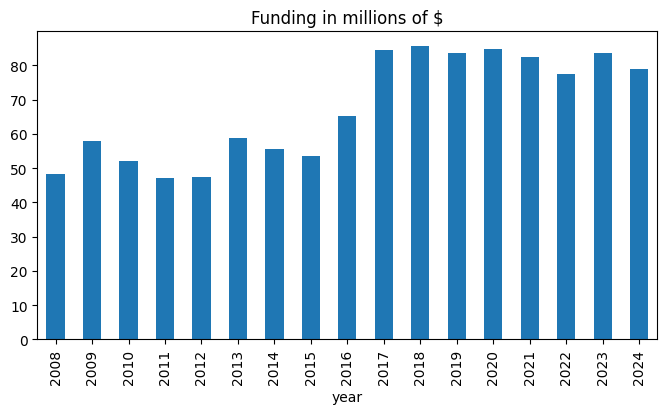

(<Axes: title={'center': 'Funding in millions of $'}, xlabel='year'>, None)

In [13]:
df_all.groupby('year')['Funding'].sum().div(1_000_000).plot(kind = 'bar', figsize=(8, 4), title="Funding in millions of $"), plt.show()


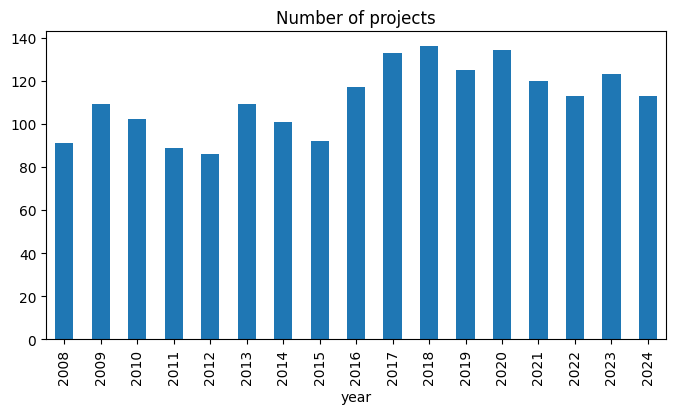

(<Axes: title={'center': 'Number of projects'}, xlabel='year'>, None)

In [14]:
df_all.groupby('year')['Funding'].count().plot(kind = 'bar', figsize=(8, 4), title="Number of projects"), plt.show()

**Show funding by institution**

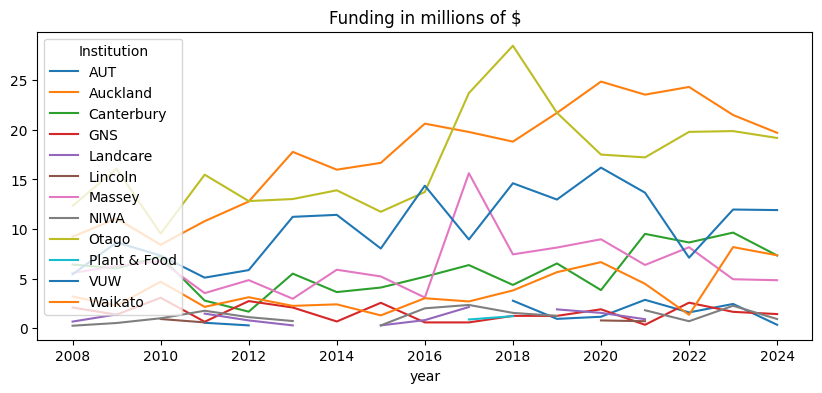

In [15]:
dfgi = df_select.groupby(['year', 'Institution'])['Funding'].sum().div(1_000_000).reset_index().pivot(index='year', columns='Institution', values='Funding').plot(figsize=(10, 4), title="Funding in millions of $"), plt.show()

**Top earners**

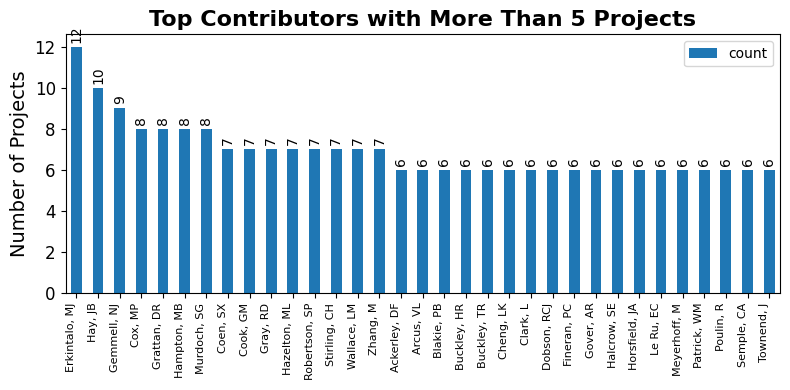

In [16]:
def top_researchers(df_tms, cut):
    # Prepare data
    top_fullnames = (df_tms.FullName
                     .value_counts()
                     .reset_index()
                     .sort_values(['count', 'FullName'], ascending = [False, True])
                     .query(f'count > {cut}')
                     .set_index(['FullName'])
                     )
    # Plot customization
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust figure size
    top_fullnames.plot(kind='bar',ax=ax, color='tab:blue')
    # Add titles and labels
    ax.set_title(f"Top Contributors with More Than {cut} Projects", fontsize=16, weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Number of Projects", fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    # Add value annotations
    for i, count in enumerate(top_fullnames['count']):
        ax.text(i, count + 0.2, str(count), ha='center', va='bottom', fontsize=10, rotation=90)
    # Rotate x-axis labels if needed (comment out if not necessary)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    # Tighten layout
    plt.tight_layout()
    # Show plot
    plt.show()
    return top_fullnames

top_fullnames = top_researchers(df_tms, 5)


**Funding by institution**

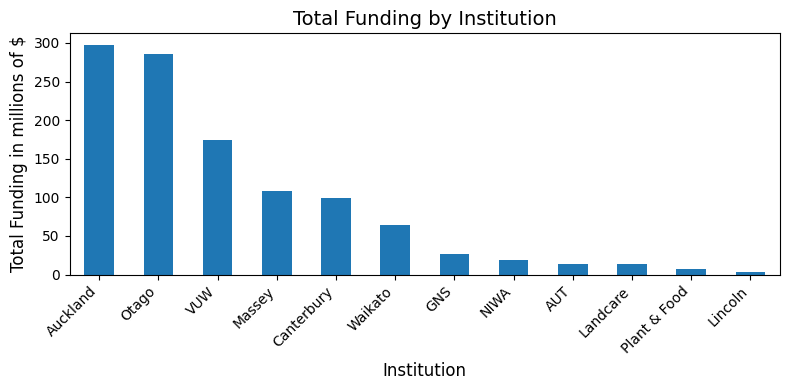

In [17]:
def bar_institutions(df):
    # Assuming df_all is the DataFrame containing 'Institution' and 'Funding'
    # Adjusting the code to prevent clipping of x-ticks

    plt.figure(figsize=(8, 4))  # Adjust figure size for better visibility
    df.groupby(['Institution'])['Funding'].sum().div(1_000_000).sort_values(ascending=False).plot(kind='bar', color='tab:blue')
    plt.title("Total Funding by Institution", fontsize=14)
    plt.ylabel("Total Funding in millions of $", fontsize=12)
    plt.xlabel("Institution", fontsize=12)
    plt.xticks(rotation=45, ha="right")  # Rotate x-tick labels for better visibility

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Display the plot
    plt.show()

bar_institutions(df_select)

**Show funding by panel**

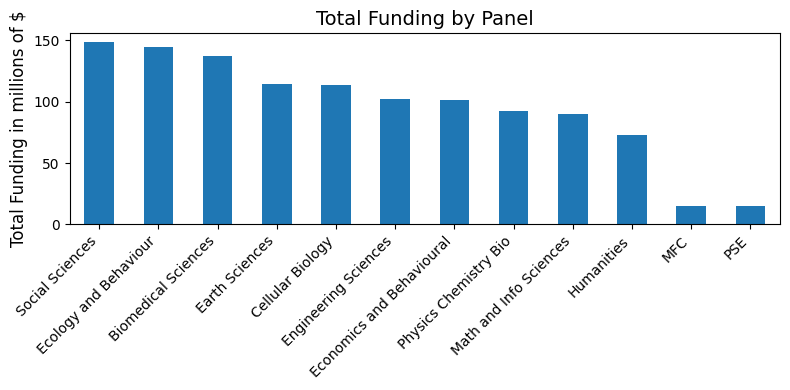

In [18]:

def bar_panels(df_all, year):
    if year is not None:  # Corrected the condition
        df_all = df_all[df_all['year'] == year]
        title_txt = f"Total Funding by Panel for Year {year}"
    else:
        title_txt = f"Total Funding by Panel"
    plt.figure(figsize=(8, 4))  # Adjust figure size for better visibility
    df_all.groupby(['Panel_Name'])['Funding'].sum().div(1_000_000).sort_values(ascending=False).plot(kind='bar', color='tab:blue')
    plt.title(title_txt, fontsize=14)
    plt.ylabel("Total Funding in millions of $", fontsize=12)
    plt.xlabel("", fontsize=12)
    plt.xticks(rotation=45, ha="right")  # Rotate x-tick labels for better visibility
    # Adjust layout to prevent clipping
    plt.tight_layout()
    # Display the plot
    plt.show()

bar_panels(df_all, None)


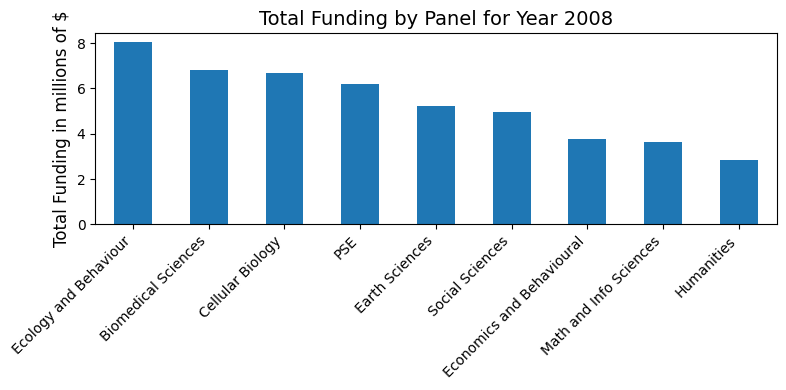

In [19]:
bar_panels(df_all, 2008)


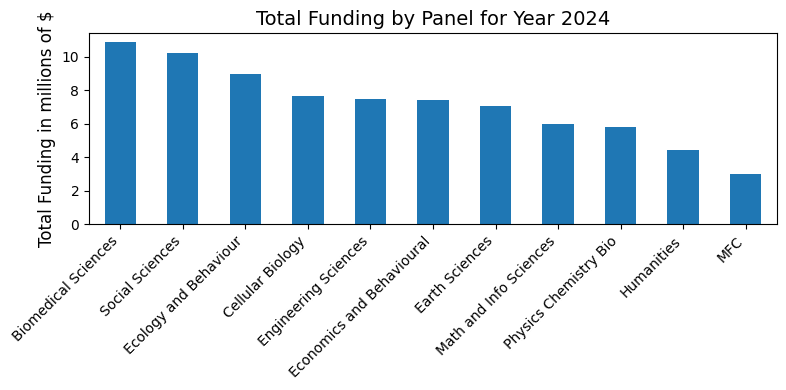

In [20]:
bar_panels(df_all, 2024)

**Indexed funding by panel over years**

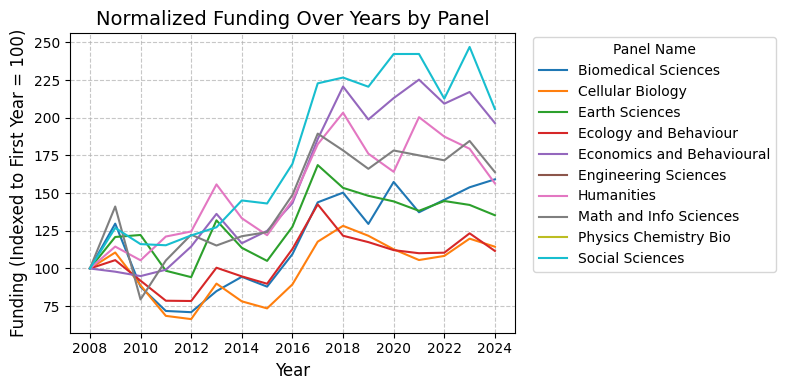

In [21]:
def plot_normalized_funding(df, figsize):
    """
    Generates a line plot of normalized funding by panel over years.

    Parameters:
    df (pd.DataFrame): Input dataframe containing 'year', 'Panel_Name', and 'Funding' columns.
    figsize (tuple): Size of the figure for the plot (default: (12, 6)).

    Returns:
    None: Displays the plot.
    """
    # Prepare the indexed DataFrame
    indexed_df = (
        df.groupby(['year', 'Panel_Name'])['Funding']
        .sum()
        .div(1_000_000)  # Convert to millions
        .reset_index()
        .pivot(index='year', columns='Panel_Name', values='Funding')
        .copy()
    )

    # Normalize to the first year (index 100)
    indexed_df = indexed_df.div(indexed_df.iloc[0]) * 100

    # Create the plot
    indexed_df.plot(figsize=figsize)

    # Add labels, title, and grid for clarity
    plt.title("Normalized Funding Over Years by Panel", fontsize=14)
    plt.ylabel("Funding (Indexed to First Year = 100)", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.legend(title="Panel Name", bbox_to_anchor=(1.025, 1.01))

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Display the plot
    plt.show()
    return indexed_df

df_index = plot_normalized_funding(df_all.query('Panel_Name != "MFC" and Panel_Name != "PSE" '), figsize=(8, 4))


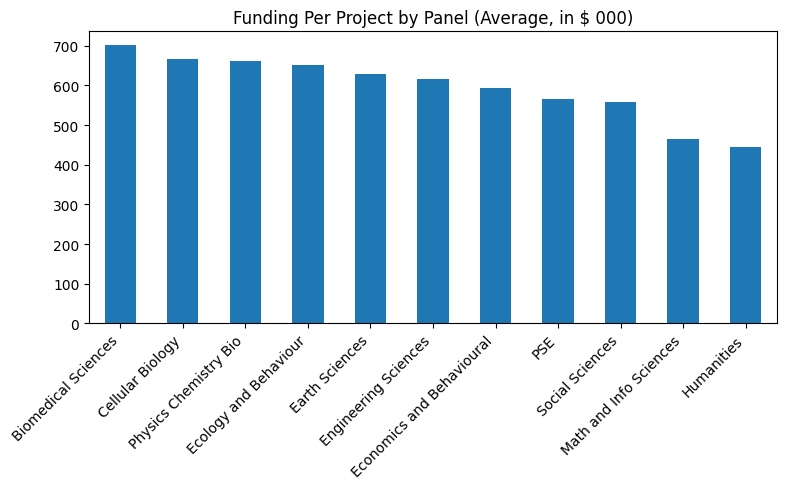

In [22]:
def per_project_fundding(df, exclude):
    df = df.copy().query('Panel_Name != "MFC"')
    df_per_project = df.groupby(['Panel_Name', 'year'])['Funding'].agg(['sum', 'count'])
    df_per_project = df_per_project['sum'].div(df_per_project['count']).div(1000)
    df_per_project.name = 'Funding per Project'

    # Reset index and pivot for plotting
    df_per_project = df_per_project.unstack().T

    df_per_project_mean_sorted = df_per_project.mean().sort_values(ascending=False)
    ax = df_per_project_mean_sorted.plot(kind='bar', figsize=(8, 5))
    plt.title("Funding Per Project by Panel (Average, in $ 000)")
    plt.xlabel("")
    plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels for readability
    plt.tight_layout()  # Adjust layout to prevent cutting off labels
    plt.show()
    return df_per_project

df_pp = per_project_fundding(df_all, 'MFC')